# **Final Project**

For our final project we try to forecast stock price on a given day from a sequence from previous days data.

We will try several models, starting from a simple LSTM adapted from our Lab 2 work.  With some modifications:

* Removing the last linear layer activation function as we are going to do a forecast and not a classification.

* Reshaping the output dimensions so that we can predict as many features as we like.

* Changing the loss function into a MSE lost.


In [ ]:
from google.colab import drive
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from torch.nn.modules import activation
import torch
from torch import nn
import torch.optim as optim

In [ ]:
drive.mount('/content/drive')
myDrive = '/content/drive/Shareddrives/Deep_Learning_2024/Final/Data/Mixed_ETF/'

Mounted at /content/drive


In [ ]:
file_path = os.path.join(myDrive,'ETF_Data.csv')
data = pd.read_csv(file_path, sep=",", header=0)

Split Data

In [ ]:
data.head()

,Date_vaw,Open_vaw,High_vaw,Low_vaw,Close_vaw,Volume_vaw,Open_vcr,High_vcr,Low_vcr,Close_vcr,...,Open_vht,High_vht,Low_vht,Close_vht,Volume_vht,Open_vnq,High_vnq,Low_vnq,Close_vnq,Volume_vnq
0,2005-02-25,54.737,55.614,54.737,55.594,20156,49.021,49.292,49.021,49.255,...,46.707,47.021,46.602,47.021,122102,39.719,40.308,39.719,40.272,39871
1,2005-02-28,55.728,55.728,54.855,55.194,47699,49.274,49.274,49.021,49.183,...,46.800,46.800,46.207,46.476,13375,40.301,40.401,39.749,40.156,72024
2,2005-03-01,55.418,55.640,55.041,55.130,17578,49.403,49.653,49.403,49.653,...,46.622,46.791,46.622,46.753,46598,40.079,40.577,40.079,40.577,45622
3,2005-03-02,54.649,55.263,54.649,55.085,11532,49.589,49.969,49.589,49.784,...,46.587,47.049,46.587,46.791,160287,40.308,40.499,40.207,40.308,20521
4,2005-03-03,55.409,55.409,54.855,55.122,28440,49.822,49.822,49.543,49.755,...,46.883,46.910,46.641,46.724,29446,40.308,40.569,40.224,40.522,12941


In [ ]:
data.pop('Date_vaw')
Train = data[:2560]
Test = data[2560:]
print(Train.shape)
print(Test.shape)
print(len(Test))

(2560, 35)
(641, 35)
641


In [ ]:
fragment_size = 10
step = 1

# Create fragmented training data
Train_Fragmented = [Train.iloc[i:i + fragment_size] for i in range(0, len(Train) - fragment_size, step)]
Train_Labels = [Train.iloc[i + fragment_size][['Close_vaw', 'Close_vgt', 'Close_vfh', 'Close_vde', 'Close_vht', 'Close_vcr']] for i in range(0, len(Train) - fragment_size, step)]

# Since we want the label to be the element at fragment_size+1, pop the first element
Train_Fragmented.pop(0)
Train_Labels.pop(0)

# Create fragmented testing data
Test_Fragmented = [Test.iloc[i:i + fragment_size] for i in range(0, len(Test) - fragment_size, step)]
Test_Labels = [Test.iloc[i + fragment_size][['Close_vaw', 'Close_vgt', 'Close_vfh', 'Close_vde', 'Close_vht', 'Close_vnq','Close_vcr']] for i in range(0, len(Test) - fragment_size, step)]

# Since we want the label to be the element at fragment_size+1, pop the first element
Test_Fragmented.pop(0)
Test_Labels.pop(0)

# Print dimensions for verification
print(f'Number of Train Fragments: {len(Train_Fragmented)}')
print(f'Number of Train Labels: {len(Train_Labels)}')
print(f'Number of Test Fragments: {len(Test_Fragmented)}')
print(f'Number of Test Labels: {len(Test_Labels)}')




Number of Train Fragments: 2549
Number of Train Labels: 2549
Number of Test Fragments: 630
Number of Test Labels: 630


In [ ]:
print(len(Train_Fragmented))
print(len(Train_Labels))
print(len(Test_Fragmented))
print(len(Test_Labels))


2549
2549
630
630


2566    106.73
2567    107.18
2568    106.59
2569    105.69
2570    106.61
2571    107.21
2572    107.29
2573    107.22
2574    106.80
2575    106.53
Name: Open_vaw, dtype: float64
2567    107.18
2568    106.59
2569    105.69
2570    106.61
2571    107.21
2572    107.29
2573    107.22
2574    106.80
2575    106.53
2576    106.81
Name: Open_vaw, dtype: float64


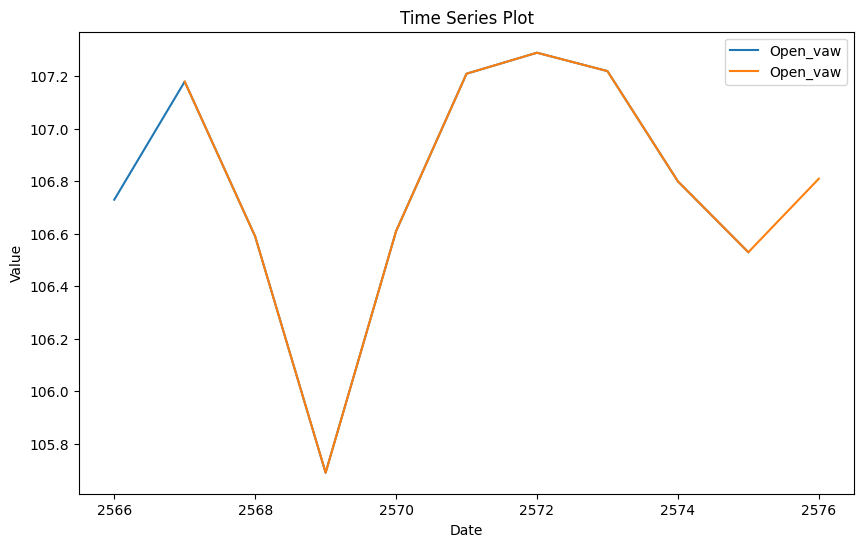

In [ ]:
print(Test_Fragmented[5]['Open_vaw'])
print(Test_Fragmented[6]['Open_vaw'])
# Plot the time series data using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(Test_Fragmented[5].index, Test_Fragmented[5]['Open_vaw'], label='Open_vaw')
plt.plot(Test_Fragmented[6].index,Test_Fragmented[6]['Open_vaw'], label='Open_vaw')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.show()

In [ ]:


# Define module encapsulating a Sequence Classifier using RNN or LSTMs and setting different architecture hyper-parameters
class Simple_LSTM(nn.Module):
  def __init__(self,
               input_size : int = 35,
               hidden_size : int = 20,
               output_size : int = 6,
               num_layers : int =  5,
               activation_function = nn.Softmax(dim = 1)):  #softmax activation function in order to get multiclass probability
    # Define RNN or LSTM architecture
    super().__init__()
    self.rnn =  nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                          num_layers=num_layers, batch_first = True)

    self.activation_function = activation_function

    self.last_linear = nn.Linear(hidden_size,output_size)

  def forward(self, X):
    _,last_states = self.rnn(X)
    # Get last hidden state for last layer. Ignore cell state in case of LSTMs
    last_hidden_state = last_states[0][-1, :, :]
    # Get sequence label probability using the last hidden state
    next_prediction = self.last_linear(last_hidden_state)
    return next_prediction

In [1]:


# Define module encapsulating a Sequence Classifier using RNN or LSTMs and setting different architecture hyper-parameters
class Conv_LSTM(nn.Module):
    def __init__(self,
                conv_filters: int=128,
                conv_kernel_size: int=1,
                input_size : int = 35,
                hidden_size : int = 64,
                output_size : int = 7,
                num_layers : int =  5
                ):  #softmax activation function in order to get multiclass probability

      # Define RNN or LSTM architecture
      super().__init__()
      self.tanh = nn.Tanh()
      self.relu = nn.ReLU()
      self.lstm =  nn.LSTM(input_size = conv_filters, hidden_size = hidden_size,num_layers=num_layers, batch_first = True)
      #self.avgpool = nn.AvgPool1d(1)

      self.conv = nn.Conv1d(input_size, out_channels = conv_filters,kernel_size = conv_kernel_size,stride=1, padding='same')
      self.last_linear = nn.Linear(hidden_size,output_size)

    def forward(self, X):
        x = self.conv(X)
        x = self.tanh(x)
        #x = self.avgpool(x)  # Uncomment if needed
        x = self.relu(x)     # Uncomment if needed
        _, (x, _) = self.lstm(x)
        x = x[-1, :, :]
        x = self.last_linear(x)
        return x

NameError: name 'nn' is not defined

In [2]:
class Conv_LSTM(nn.Module):
    def __init__(self,
                 conv_filters: int=128,
                 conv_kernel_size: int=1,
                 input_size: int=35,
                 hidden_size: int=64,
                 output_size: int=7,
                 num_layers: int=1
                ):
        super(Conv_LSTM, self).__init__()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.conv = nn.Conv1d(in_channels=35, out_channels=conv_filters, kernel_size=conv_kernel_size, stride=1, padding=1)
        self.lstm = nn.LSTM(input_size=conv_filters, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.last_linear = nn.Linear(hidden_size, output_size)
        self.avgpool = nn.AvgPool1d(1)


    def forward(self, X):
        # Assuming X has dimensions [batch_size, sequence_length, num_features]
        x = self.conv(X.permute(0, 2, 1))  # Permute to [batch_size, num_features, sequence_length]
        x = self.tanh(x)
        x = self.avgpool(x)
        x = self.relu(x)
        _, (x, _) = self.lstm(x.permute(0, 2, 1))
        x = x[-1, :, :]
        x = self.last_linear(x)
        return x


# Example usage:
conv_filters = 64
conv_kernel_size = 3
input_size = 35
hidden_size = 128
output_size = 7
num_layers = 1

model = Conv_LSTM(conv_filters=conv_filters, conv_kernel_size=conv_kernel_size, input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)

input_tensor = torch.randn(2549, 10, 35)  # Example input tensor with dimensions [2549, 10, 35]
output = model(input_tensor)
print(output.shape)  # Assuming output is [2549, 7]


NameError: name 'nn' is not defined

In [ ]:
def train_simple_LSTM(X_train, Y_train, model, optimizer, loss_func, epochs=100):
    loss_its = []
    for iter in range(epochs):
      optimizer.zero_grad()
      output = model(X_train)
      loss = loss_func(output.log(),Y_train)
      loss_its.append(loss.item())
      loss.backward()
      optimizer.step()
    print(f'Final loss: {loss.item()}')
    return np.asarray(loss_its)

In [ ]:
tensor_list = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Train_Fragmented]
X_train = torch.stack(tensor_list)
label_tensor_list = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Train_Labels]
Y_train =  torch.stack(label_tensor_list)

tensor_list_test = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Test_Fragmented]
X_test = torch.stack(tensor_list_test)
label_tensor_list_test = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Test_Labels]
Y_test =  torch.stack(label_tensor_list_test)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming X_train, Y_train, X_test, Y_test are already defined and normalized
X_train_pt = X_train.float().to(device)
Y_train_pt = Y_train.float().to(device)
X_test_pt = X_test.float().to(device)
Y_test_pt = Y_test.float().to(device)

train_dataset = torch.utils.data.TensorDataset(X_train_pt, Y_train_pt)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
conv_filters=256
conv_kernel_size=1
input_size =35
hidden_size = 512
num_layers = 2
output_size = 6

# Define model, loss function, and optimizer
model = Conv_LSTM(conv_kernel_size = conv_kernel_size,conv_filters = conv_filters,input_size=input_size, hidden_size=hidden_size, output_size = output_size, num_layers=num_layers).to(device)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
num_epochs = 1000
loss_its = []
for iter in range(num_epochs):
  model.train()
  optimizer.zero_grad()
  output = model(X_train_pt)
  loss = loss_func(output,Y_train_pt)
  loss_its.append(loss.item())
  loss.backward()
  optimizer.step()

  if( iter%100 == 0):
    print(f'Final loss: {loss.item()}')

#loss_history = train_simple_LSTM(X_train_pt, Y_train_pt, model, optimizer, loss_func, epochs=num_epochs)


Final loss: 4505.78857421875


In [ ]:
# Training loop
num_epochs = 1000
loss_its = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    # Iterate over batches in the DataLoader
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()

        # Move batch data to the device
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)

        # Forward pass
        output = model(batch_X)

        # Compute loss
        loss = loss_func(output, batch_Y)
        epoch_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Compute average loss for the epoch

    epoch_loss /= len(train_loader)
    loss_its.append(epoch_loss)

    # Print epoch statistics
    if epoch % 100 == 0:
        output_test = model(X_train_pt)
        test_loss = loss_func(output_test, batch_Y)
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss},Test_loss: {test_loss}')

print('Training complete.')


Loss Histogram

# Histogram

In [ ]:
Y_predicted = model(X_train_pt).cpu().detach().numpy()
Y = Y_train_pt.cpu().detach().numpy()
print(Y_predicted)

In [ ]:
file_path = os.path.join(myDrive,'Y_predicted.csv')
pd.DataFrame(Y_predicted).to_csv(file_path, index=False)

In [ ]:
Y_predicted = model(X_train_pt).cpu().detach().numpy()
Y = Y_train_pt.cpu().detach().numpy()
print(Y_predicted)

plt.figure(figsize=(12, 8))
plt.plot(Y_predicted[0])
plt.plot(Y[0])
plt.title('Price evolution vs next-day prediction')
plt.xlabel('Sample Index')
plt.ylabel('price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt


# Ensure `Y` is 2D by squeezing the last dimension
Y_squeezed = Y.squeeze()

# Check the shapes (for debugging purposes)
print("Y_predicted shape:", Y_predicted.shape)
print("Y shape after squeezing:", Y_squeezed.shape)

# Plot the actual signals
plt.figure(figsize=(12, 8))
if Y_squeezed.ndim == 2:
  for i in range(Y_squeezed.shape[1]):
      plt.plot(Y_squeezed[:, i], label=f"Actual Signal {i+1}")
else:
  plt.plot(Y_squeezed[:], label=f"Actual Signal {1}")

# Ensure Y_predicted is compatible for plotting
if Y_predicted.shape[1] == 1:
    # If Y_predicted is 1D, we plot it directly
    plt.plot(Y_predicted, label="Predicted Signal", linestyle='--')
elif Y_predicted.ndim == 2 and Y_predicted.shape[1] == Y_squeezed.shape[1]:
    # If Y_predicted is 2D, plot each predicted signal
    for i in range(Y_predicted.shape[1]):
        plt.plot(Y_predicted[:, i], linestyle='--', label=f"Predicted Signal {i+1}")

plt.title('First attempt CNN-LSTM')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()
